# <center>Capstone Project - The Battle of Neighborhoods

## Import libraries

In [245]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


## Prepare the data

Get Manchester postcode and corresponding coverage areas data from Wikipedia table

In [3]:
url='https://en.wikipedia.org/wiki/M_postcode_area'
website_url = requests.get(url).text

soup = BeautifulSoup(website_url,'html.parser')

In [4]:
Man_table = soup.find('table',{'class':'wikitable sortable'})

In [261]:
df_Man_raw = pd.read_html(str(Man_table))[0]
df_Man_raw.head()

,Postcode district,Post town,Coverage,Local authority area(s)
0,M1,MANCHESTER,"Piccadilly, City Centre, Market Street",Manchester
1,M2,MANCHESTER,"Deansgate, City Centre",Manchester
2,"M3(Sectors 1, 2, 3, 4 and 9)",MANCHESTER,"City Centre, Deansgate, Castlefield",Manchester
3,"M3(Sectors 5, 6 and 7)",SALFORD,"Blackfriars, Greengate, Trinity",Salford
4,M4,MANCHESTER,"Ancoats, Northern Quarter, Strangeways",Manchester


In [262]:
df_Man = df_Man_raw.drop(columns=['Post town','Local authority area(s)'])
df_Man.head()

,Postcode district,Coverage
0,M1,"Piccadilly, City Centre, Market Street"
1,M2,"Deansgate, City Centre"
2,"M3(Sectors 1, 2, 3, 4 and 9)","City Centre, Deansgate, Castlefield"
3,"M3(Sectors 5, 6 and 7)","Blackfriars, Greengate, Trinity"
4,M4,"Ancoats, Northern Quarter, Strangeways"


The data of coordinates of postcodes can be found online and saved into a csv file

In [48]:
df_Man_geo = pd.read_csv('Manchester_Postcode_Coordinates.csv')
df_Man_geo.head()

,Postcode district,Latitude,Longitude
0,M1,53.479635,-2.230093
1,M2,53.476203,-2.247281
2,"M3(Sectors 1, 2, 3, 4 and 9)",53.487457,-2.247121
3,"M3(Sectors 5, 6 and 7)",53.483616,-2.248861
4,M4,53.482435,-2.236254


In [238]:
#check if df_Man and df_Man_geo have same number of rows, so that no information is missing
print(len(df_Man),len(df_Man_geo))

52 52


In [50]:
df_Man_full = pd.merge(df_Man,df_Man_geo,on='Postcode district')
df_Man_full.head()

,Postcode district,Coverage,Latitude,Longitude
0,M1,"Piccadilly, City Centre, Market Street",53.479635,-2.230093
1,M2,"Deansgate, City Centre",53.476203,-2.247281
2,"M3(Sectors 1, 2, 3, 4 and 9)","City Centre, Deansgate, Castlefield",53.487457,-2.247121
3,"M3(Sectors 5, 6 and 7)","Blackfriars, Greengate, Trinity",53.483616,-2.248861
4,M4,"Ancoats, Northern Quarter, Strangeways",53.482435,-2.236254


## Visualise the coverages of Manchester

In [57]:
latitude = 53.4808
longitude = -2.2426
print('The geograpical coordinate of Manchster are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manchster are 53.4808, -2.2426.


In [271]:
import folium as fl

map_tor = fl.Map(location=[latitude,longitude],zoom_start=10)

for lat,lng,coverage in zip(df_Man_full['Latitude'],df_Man_full['Longitude'],df_Man_full['Coverage']):
    label = '{}'.format(coverage)
    label = fl.Popup(label, parse_html=True)
    fl.CircleMarker(
    [lat,lng],
    radius=6,
    popup=label,
    color='blue',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(map_tor)
map_tor

 ## Use the Foursquare API to explore each coverage area

In [60]:
CLIENT_ID = 'HIS2TERGGSES1T31PV1ZAENXQRMD24I5IVIRX0HFA4KKBUJR' 
CLIENT_SECRET = 'BFVCMBE5UFP0XGMB3H0UKIWWGXTZGIWWCAIZ3KWJMBOL1PHU' 
VERSION = '20180605' 

### Get nearby venues for all coverage areas

In [239]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Coverage', 
                  'Coverage Latitude', 
                  'Coverage Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [240]:
Man_venues = getNearbyVenues(names=df_Man_full['Coverage'],
                                   latitudes=df_Man_full['Latitude'],
                                   longitudes=df_Man_full['Longitude']
                                  )
print('Finished!')

Piccadilly, City Centre, Market Street
Deansgate, City Centre
City Centre, Deansgate, Castlefield
Blackfriars, Greengate, Trinity
Ancoats, Northern Quarter, Strangeways
Ordsall, Seedley, Weaste, University
Pendleton, Irlams o' th' Height, Langworthy, Seedley, Charlestown
Higher Broughton, Cheetwood, Lower Broughton, Kersal
Crumpsall, Cheetham Hill
Harpurhey, Blackley
Clayton, Openshaw, Beswick
Ardwick, Longsight, Chorlton-on-Medlock
Ardwick, Longsight, Chorlton-on-Medlock
Fallowfield, Moss Side, Ladybarn, Rusholme, Victoria Park, Longsight
Hulme, Manchester Science Park, Old Trafford
Firswood, Old Trafford, Whalley Range, Moss Side
Trafford Park, The Trafford Centre
Abbey Hey, Gorton
Levenshulme, Burnage
Didsbury, Withington
Chorlton-cum-Hardy, Barlow Moor
Wythenshawe, Northenden, Sharston Industrial Area
Baguley, Brooklands (Manchester and Trafford), Roundthorn Industrial Estate
Middleton, Alkrington, Chadderton
Prestwich, Sedgley Park, Simister
Radcliffe, Stoneclough
Swinton, Clifton

In [241]:
Man_venues.head()

,Coverage,Coverage Latitude,Coverage Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Takk,53.481130,-2.232531,Coffee Shop
1,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Northern Monk Refectory,53.481286,-2.232283,Beer Bar
2,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Tariff & Dale,53.481002,-2.232894,Bar
3,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Idle Hands,53.481288,-2.233041,Coffee Shop
4,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Port Street Beer House,53.482054,-2.231739,Beer Bar


### Which area has the most number of venues

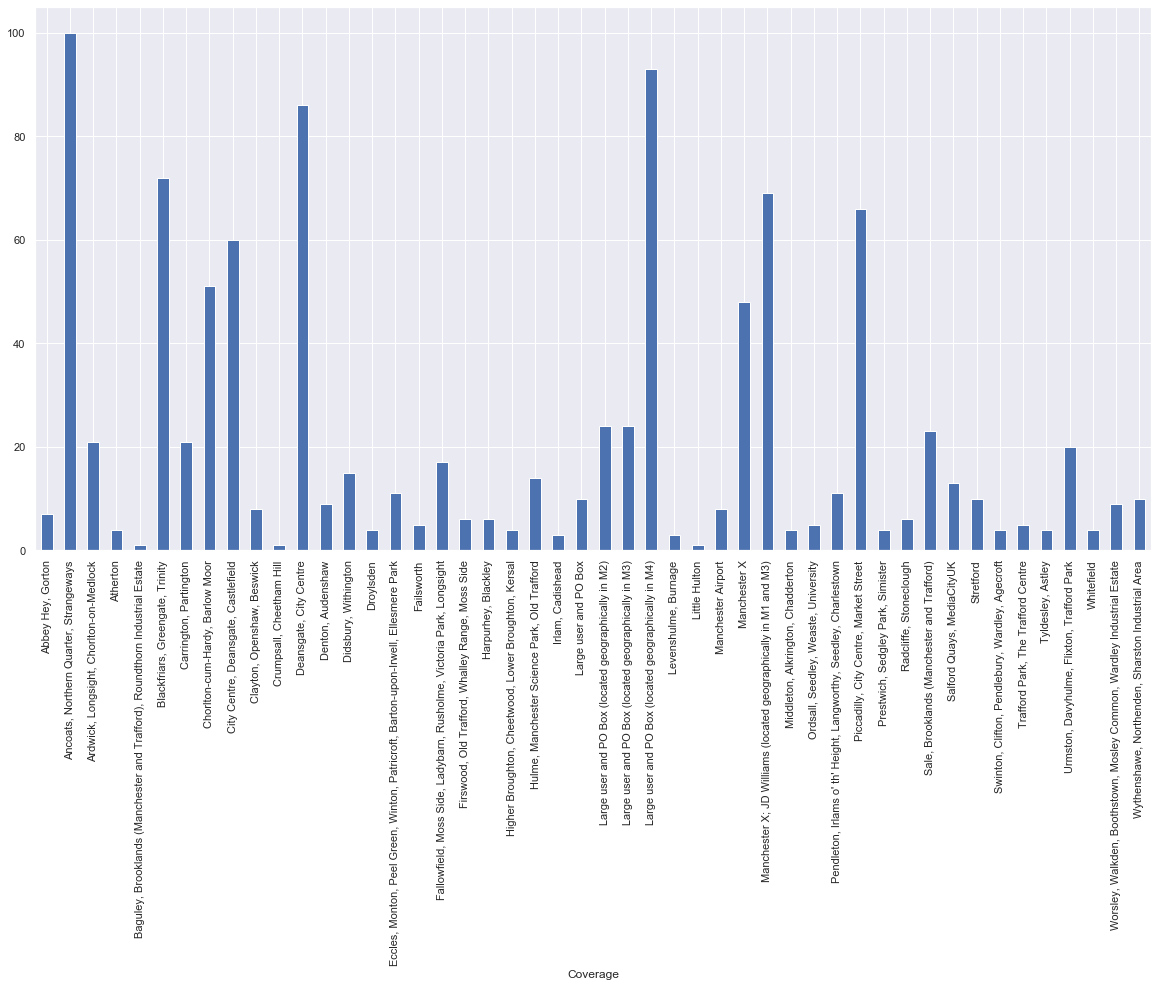

In [251]:
sns.set()
plt.subplots(figsize=(20,10))
Man_venues.groupby('Coverage')['Venue'].count().plot(kind='bar')

## Use Foursquare to find the category tree 

Since I want to open a restaurant, I want to see how venues with a category as Food are distributed in the city, and the taste preference of each area throughout the city.

Firstly, use categories endpoint to explore more about the categories in Foursquare data

In [70]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

results_cat = requests.get(url).json()
results_cat

{'meta': {'code': 200, 'requestId': '5f2ae224c8e3474a39bfc551'},
 'response': {'categories': [{'id': '4d4b7104d754a06370d81259',
    'name': 'Arts & Entertainment',
    'pluralName': 'Arts & Entertainment',
    'shortName': 'Arts & Entertainment',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
     'suffix': '.png'},
    'categories': [{'id': '56aa371be4b08b9a8d5734db',
      'name': 'Amphitheater',
      'pluralName': 'Amphitheaters',
      'shortName': 'Amphitheater',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4fceea171983d5d06c3e9823',
      'name': 'Aquarium',
      'pluralName': 'Aquariums',
      'shortName': 'Aquarium',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4bf58dd8d48988d1e1931735',
      'name': 'A

I find that category has a parent category named as Type. Therefore, I extract the Type for each category.

In [75]:
df_cat = pd.DataFrame(columns=['Parent Category','Category'])

for cat_type in results_cat['response'].get('categories'):    
    df_temp = pd.DataFrame(columns=['Parent Category','Category'])
    json_cat = pd.json_normalize(cat_type.get('categories'))    
    df_temp['Category'] = json_cat['name']
    df_temp['Parent Category'] = cat_type.get('name')
    df_cat = df_cat.append(df_temp)
    
    sub_cat = json_cat['categories']
    for sub_cat_type in sub_cat:     
        if len(sub_cat_type)>0:
            df_temp = pd.DataFrame(columns=['Parent Category','Category'])
            json_sub_cat = pd.json_normalize(sub_cat_type)
            df_temp['Category'] = json_sub_cat['name']
            df_temp['Parent Category'] = cat_type.get('name')
            df_cat = df_cat.append(df_temp)
            
df_cat.head()

,Parent Category,Category
0,Arts & Entertainment,Amphitheater
1,Arts & Entertainment,Aquarium
2,Arts & Entertainment,Arcade
3,Arts & Entertainment,Art Gallery
4,Arts & Entertainment,Bowling Alley


We can see there is a Food type, which is want I'm looking for.

In [269]:
df_cat['Parent Category'].unique()

array(['Arts & Entertainment', 'College & University', 'Event', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Residence', 'Shop & Service',
       'Travel & Transport'], dtype=object)

In [91]:
df_cat.rename(columns={"Category":"Venue Category"}, inplace=True)

In [99]:
df_Man_merge = pd.merge(Man_venues,df_cat, on='Venue Category' )
print(df_Man_merge.shape)
df_Man_merge.head()


(979, 8)


,Coverage,Coverage Latitude,Coverage Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Parent Category
0,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Takk,53.481130,-2.232531,Coffee Shop,Food
1,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Idle Hands,53.481288,-2.233041,Coffee Shop,Food
2,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Ezra & Gil,53.482068,-2.232842,Coffee Shop,Food
3,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Fig and Sparrow,53.482626,-2.235609,Coffee Shop,Food
4,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Ancoats Coffee Co,53.483536,-2.227407,Coffee Shop,Food


## Select the venue with category is Food

In [102]:
df_Man_food = df_Man_merge[df_Man_merge['Parent Category']=='Food']
print(df_Man_food.shape)
df_Man_food.head()

(434, 8)


,Coverage,Coverage Latitude,Coverage Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Parent Category
0,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Takk,53.481130,-2.232531,Coffee Shop,Food
1,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Idle Hands,53.481288,-2.233041,Coffee Shop,Food
2,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Ezra & Gil,53.482068,-2.232842,Coffee Shop,Food
3,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Fig and Sparrow,53.482626,-2.235609,Coffee Shop,Food
4,"Piccadilly, City Centre, Market Street",53.479635,-2.230093,Ancoats Coffee Co,53.483536,-2.227407,Coffee Shop,Food


### Which area has the most number of food venues

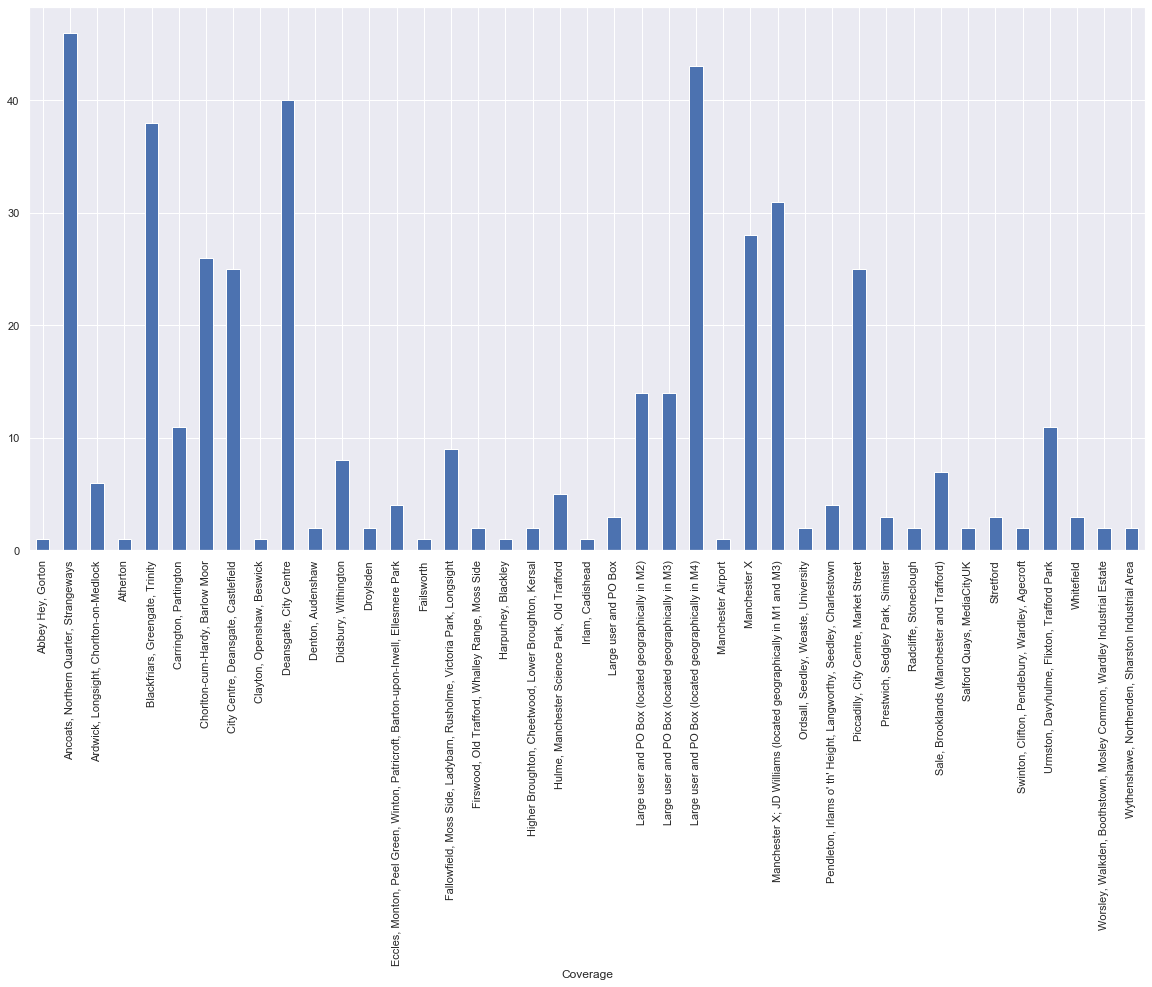

In [258]:
sns.set()
plt.subplots(figsize=(20,10))
df_Man_food.groupby('Coverage')['Venue Category'].count().plot(kind='bar')

### Analyse each coverage with venues type is Food

Use One-hot encoding to convert categorical data to numerical data and get the mean of the frequency of occurrence of each category


In [107]:
# one hot encoding
Man_onehot = pd.get_dummies(df_Man_food[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
Man_onehot['Coverage'] = df_Man_food['Coverage'] 

# move neighbourhood column to the first column
fixed_columns = [Man_onehot.columns[-1]] + list(Man_onehot.columns[:-1])
Man_onehot = Man_onehot[fixed_columns]

print(Man_onehot.shape)
Man_onehot.head()

(434, 58)


,Coverage,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Bubble Tea Shop,Buffet,...,Spanish Restaurant,Steakhouse,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Piccadilly, City Centre, Market Street",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Piccadilly, City Centre, Market Street",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Piccadilly, City Centre, Market Street",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Piccadilly, City Centre, Market Street",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Piccadilly, City Centre, Market Street",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
Man_onehot_grouped = Man_onehot.groupby('Coverage').mean().reset_index()
print(Man_onehot_grouped.shape)
Man_onehot_grouped.head()

(41, 58)


,Coverage,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Bubble Tea Shop,Buffet,...,Spanish Restaurant,Steakhouse,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Abbey Hey, Gorton",0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,"Ancoats, Northern Quarter, Strangeways",0.065217,0.021739,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.021739,0.0,0.000000,0.065217,0.0,0.0,0.000000,0.021739,0.0
2,"Ardwick, Longsight, Chorlton-on-Medlock",0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,Atherton,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,"Blackfriars, Greengate, Trinity",0.026316,0.052632,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.052632,0.0,0.026316,0.026316,0.0,0.0,0.026316,0.000000,0.0


### Create the function to find n tops common food venues for a coverage

Here I find the top 5 common food venues for each coverage

In [112]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [114]:
num_top_venues = 5

# create columns according to number of top venues
columns = ['Coverage','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']

# create a new dataframe
Man_coverage_venues_sorted = pd.DataFrame(columns=columns)
Man_coverage_venues_sorted['Coverage'] = Man_onehot_grouped['Coverage']

for ind in np.arange(Man_onehot_grouped.shape[0]):
    Man_coverage_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Man_onehot_grouped.iloc[ind, :], num_top_venues)

Man_coverage_venues_sorted.head()

,Coverage,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Abbey Hey, Gorton",Sandwich Place,Vietnamese Restaurant,Caucasian Restaurant,Fried Chicken Joint,Food Truck
1,"Ancoats, Northern Quarter, Strangeways",Coffee Shop,Pizza Place,Tea Room,Café,American Restaurant
2,"Ardwick, Longsight, Chorlton-on-Medlock",Indian Restaurant,Fast Food Restaurant,Dessert Shop,Vietnamese Restaurant,Chinese Restaurant
3,Atherton,Sandwich Place,Vietnamese Restaurant,Caucasian Restaurant,Fried Chicken Joint,Food Truck
4,"Blackfriars, Greengate, Trinity",Coffee Shop,Italian Restaurant,Restaurant,Sandwich Place,Asian Restaurant


## Cluster the coverages using the types of food around the area

In [149]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

Man_grouped_clustering = Man_onehot_grouped.drop('Coverage', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Man_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 3, 1, 2, 3, 1, 3, 3, 0, 3, 4, 3, 4, 2, 4, 3, 3, 3, 0, 4, 3, 1,
       3, 3, 3, 0, 3, 3, 4, 4, 3, 3, 1, 3, 2, 4, 2, 1, 1, 4, 0],
      dtype=int32)

In [172]:
# add clustering labels
#Man_coverage_venues_sorted.drop(['Cluster Label'],axis=1,inplace=True)
#Man_coverage_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

In [170]:
Man_clustered = Man_coverage_venues_sorted.join(df_Man_full.set_index('Coverage'), on='Coverage')
Man_clustered.head()

,Cluster Label,Coverage,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postcode district,Latitude,Longitude
0,2,"Abbey Hey, Gorton",Sandwich Place,Vietnamese Restaurant,Caucasian Restaurant,Fried Chicken Joint,Food Truck,M18,53.461855,-2.178155
1,3,"Ancoats, Northern Quarter, Strangeways",Coffee Shop,Pizza Place,Tea Room,Café,American Restaurant,M4,53.482435,-2.236254
2,1,"Ardwick, Longsight, Chorlton-on-Medlock",Indian Restaurant,Fast Food Restaurant,Dessert Shop,Vietnamese Restaurant,Chinese Restaurant,M12,53.457804,-2.199358
2,1,"Ardwick, Longsight, Chorlton-on-Medlock",Indian Restaurant,Fast Food Restaurant,Dessert Shop,Vietnamese Restaurant,Chinese Restaurant,M13,53.453993,-2.197968
3,2,Atherton,Sandwich Place,Vietnamese Restaurant,Caucasian Restaurant,Fried Chicken Joint,Food Truck,M46,53.522638,-2.491418


## Visualise the clustering results

In [135]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [270]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cov, cluster in zip(Man_clustered['Latitude'], Man_clustered['Longitude'], Man_clustered['Coverage'], Man_clustered['Cluster Label']):
    label = folium.Popup(str(cov) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [183]:
Cluster0 = Man_clustered.loc[Man_clustered['Cluster Label'] == 0, Man_clustered.columns[[1] + list(range(2, 8))]]
Cluster0

,Coverage,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postcode district
8,"Clayton, Openshaw, Beswick",Coffee Shop,Vietnamese Restaurant,Greek Restaurant,Fried Chicken Joint,Food Truck,M11
18,"Higher Broughton, Cheetwood, Lower Broughton, ...",Bagel Shop,Coffee Shop,Vietnamese Restaurant,Chinese Restaurant,Fried Chicken Joint,M7
25,Manchester Airport,Coffee Shop,Vietnamese Restaurant,Greek Restaurant,Fried Chicken Joint,Food Truck,M90
40,"Wythenshawe, Northenden, Sharston Industrial Area",Coffee Shop,Vietnamese Restaurant,Greek Restaurant,Fried Chicken Joint,Food Truck,M22


In [184]:
Cluster1 = Man_clustered.loc[Man_clustered['Cluster Label'] == 1, Man_clustered.columns[[1] + list(range(2, 8))]]
Cluster1

,Coverage,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postcode district
2,"Ardwick, Longsight, Chorlton-on-Medlock",Indian Restaurant,Fast Food Restaurant,Dessert Shop,Vietnamese Restaurant,Chinese Restaurant,M12
2,"Ardwick, Longsight, Chorlton-on-Medlock",Indian Restaurant,Fast Food Restaurant,Dessert Shop,Vietnamese Restaurant,Chinese Restaurant,M13
5,"Carrington, Partington",Indian Restaurant,Italian Restaurant,Café,Pizza Place,Steakhouse,M31
21,Large user and PO Box,Pizza Place,Turkish Restaurant,Indian Restaurant,Caucasian Restaurant,Food Truck,M60(Sector 9)
32,"Radcliffe, Stoneclough",Gastropub,Indian Restaurant,Chinese Restaurant,Fried Chicken Joint,Food Truck,M26
37,"Urmston, Davyhulme, Flixton, Trafford Park",Indian Restaurant,Italian Restaurant,Café,Pizza Place,Steakhouse,M41
38,Whitefield,Indian Restaurant,Bakery,Vietnamese Restaurant,Chinese Restaurant,Fried Chicken Joint,M45


In [185]:
Cluster2 = Man_clustered.loc[Man_clustered['Cluster Label'] == 2, Man_clustered.columns[[1] + list(range(2, 8))]]
Cluster2

,Coverage,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postcode district
0,"Abbey Hey, Gorton",Sandwich Place,Vietnamese Restaurant,Caucasian Restaurant,Fried Chicken Joint,Food Truck,M18
3,Atherton,Sandwich Place,Vietnamese Restaurant,Caucasian Restaurant,Fried Chicken Joint,Food Truck,M46
13,"Eccles, Monton, Peel Green, Winton, Patricroft...",Sandwich Place,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Caucasian Restaurant,M30
34,"Salford Quays, MediaCityUK",Sandwich Place,Vietnamese Restaurant,Caucasian Restaurant,Fried Chicken Joint,Food Truck,M50
36,"Swinton, Clifton, Pendlebury, Wardley, Agecroft",English Restaurant,Sandwich Place,Vietnamese Restaurant,Caucasian Restaurant,Fried Chicken Joint,M27


In [186]:
Cluster3 = Man_clustered.loc[Man_clustered['Cluster Label'] == 3, Man_clustered.columns[[1] + list(range(2, 8))]]
Cluster3

,Coverage,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postcode district
1,"Ancoats, Northern Quarter, Strangeways",Coffee Shop,Pizza Place,Tea Room,Café,American Restaurant,M4
4,"Blackfriars, Greengate, Trinity",Coffee Shop,Italian Restaurant,Restaurant,Sandwich Place,Asian Restaurant,"M3(Sectors 5, 6 and 7)"
6,"Chorlton-cum-Hardy, Barlow Moor",Pizza Place,Café,Coffee Shop,Deli / Bodega,Turkish Restaurant,M21
7,"City Centre, Deansgate, Castlefield",Italian Restaurant,Coffee Shop,Tea Room,Indian Restaurant,American Restaurant,"M3(Sectors 1, 2, 3, 4 and 9)"
9,"Deansgate, City Centre",Italian Restaurant,Coffee Shop,Restaurant,Asian Restaurant,Café,M2
11,"Didsbury, Withington",Pizza Place,Vegetarian / Vegan Restaurant,Thai Restaurant,Café,Restaurant,M20
15,"Fallowfield, Moss Side, Ladybarn, Rusholme, Vi...",Fast Food Restaurant,Pizza Place,Asian Restaurant,Greek Restaurant,Fish & Chips Shop,M14
16,"Firswood, Old Trafford, Whalley Range, Moss Side",Tibetan Restaurant,Chinese Restaurant,Vietnamese Restaurant,Caucasian Restaurant,Fried Chicken Joint,M16
17,"Harpurhey, Blackley",Breakfast Spot,Vietnamese Restaurant,Chinese Restaurant,Fried Chicken Joint,Food Truck,M9
20,"Irlam, Cadishead",Food Truck,Vietnamese Restaurant,Greek Restaurant,Fried Chicken Joint,Food Court,M44


In [187]:
Cluster4 = Man_clustered.loc[Man_clustered['Cluster Label'] == 4, Man_clustered.columns[[1] + list(range(2, 8))]]
Cluster4

,Coverage,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postcode district
10,"Denton, Audenshaw",Fast Food Restaurant,Café,Vietnamese Restaurant,Chinese Restaurant,Fried Chicken Joint,M34
12,Droylsden,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Fried Chicken Joint,M43
14,Failsworth,Fast Food Restaurant,Vietnamese Restaurant,Greek Restaurant,Fried Chicken Joint,Food Truck,M35
19,"Hulme, Manchester Science Park, Old Trafford",Gastropub,Fast Food Restaurant,Restaurant,Caucasian Restaurant,Fried Chicken Joint,M15
28,"Ordsall, Seedley, Weaste, University",Fast Food Restaurant,Burger Joint,Vietnamese Restaurant,Chinese Restaurant,Fried Chicken Joint,M5
29,"Pendleton, Irlams o' th' Height, Langworthy, S...",Fast Food Restaurant,Burger Joint,Coffee Shop,Vietnamese Restaurant,Chinese Restaurant,M6
35,Stretford,Food Court,Fast Food Restaurant,Coffee Shop,Vietnamese Restaurant,Greek Restaurant,M32
39,"Worsley, Walkden, Boothstown, Mosley Common, W...",Fast Food Restaurant,Coffee Shop,Vietnamese Restaurant,Greek Restaurant,Fried Chicken Joint,M28


## Analyse the most number of food types in each coverage area

In [246]:
Series0=Cluster0['1st Most Common Venue'].append(Cluster0['2nd Most Common Venue'],ignore_index=True).append(Cluster0['3rd Most Common Venue'],ignore_index=True).append(Cluster0['4th Most Common Venue'],ignore_index=True).append(Cluster0['5th Most Common Venue'],ignore_index=True)
Series1=Cluster1['1st Most Common Venue'].append(Cluster1['2nd Most Common Venue'],ignore_index=True).append(Cluster1['3rd Most Common Venue'],ignore_index=True).append(Cluster1['4th Most Common Venue'],ignore_index=True).append(Cluster1['5th Most Common Venue'],ignore_index=True)
Series2=Cluster2['1st Most Common Venue'].append(Cluster2['2nd Most Common Venue'],ignore_index=True).append(Cluster2['3rd Most Common Venue'],ignore_index=True).append(Cluster2['4th Most Common Venue'],ignore_index=True).append(Cluster2['5th Most Common Venue'],ignore_index=True)
Series3=Cluster3['1st Most Common Venue'].append(Cluster3['2nd Most Common Venue'],ignore_index=True).append(Cluster3['3rd Most Common Venue'],ignore_index=True).append(Cluster3['4th Most Common Venue'],ignore_index=True).append(Cluster3['5th Most Common Venue'],ignore_index=True)
Series4=Cluster4['1st Most Common Venue'].append(Cluster4['2nd Most Common Venue'],ignore_index=True).append(Cluster4['3rd Most Common Venue'],ignore_index=True).append(Cluster4['4th Most Common Venue'],ignore_index=True).append(Cluster4['5th Most Common Venue'],ignore_index=True)

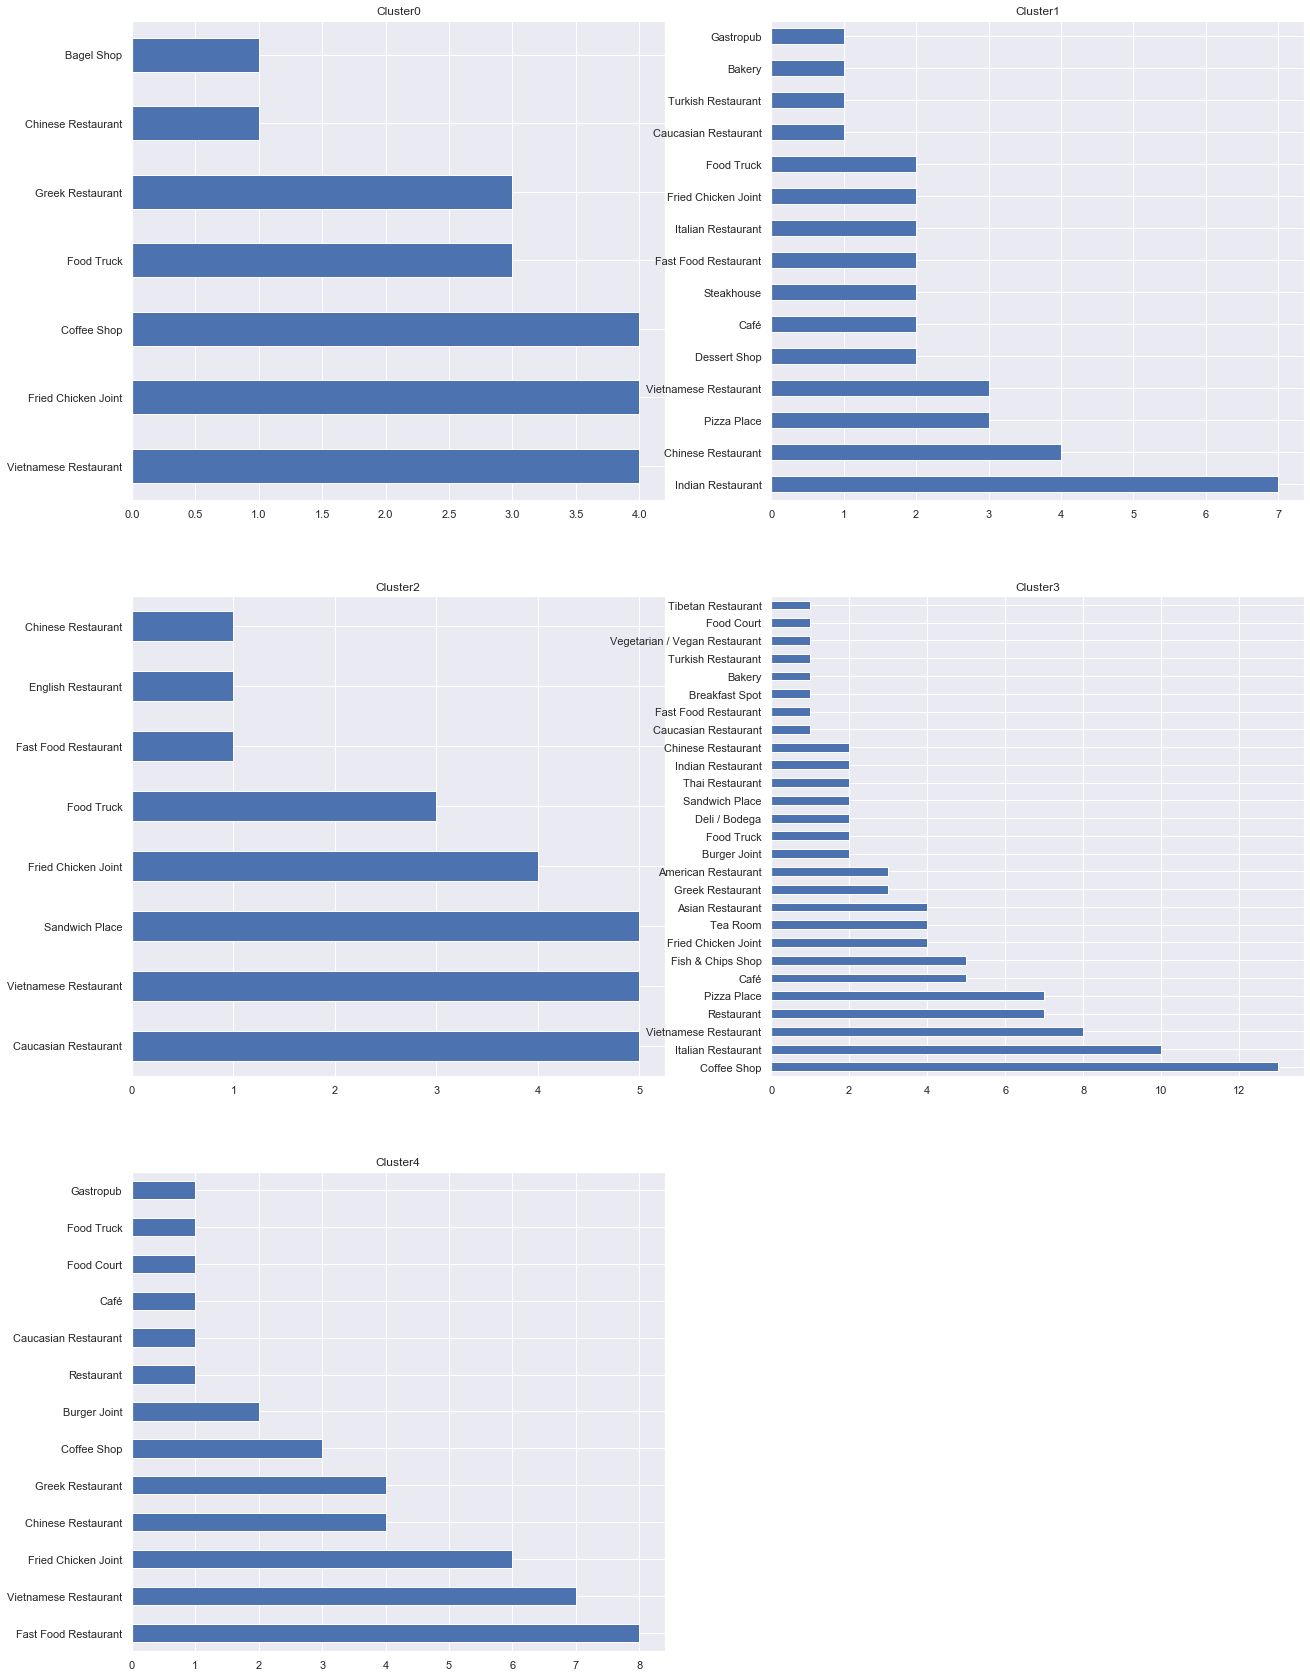

In [242]:
sns.set()
plt.subplots(figsize=(21,30))
plt.subplot(3,2,1)
Series0.value_counts().plot(kind='barh',title='Cluster0')
plt.subplot(3,2,2)
Series1.value_counts().plot(kind='barh',title='Cluster1')
plt.subplot(3,2,3)
Series2.value_counts().plot(kind='barh',title='Cluster2')
plt.subplot(3,2,4)
Series3.value_counts().plot(kind='barh',title='Cluster3')
plt.subplot(3,2,5)
Series4.value_counts().plot(kind='barh',title='Cluster4')